This is a notebook to write code to evaluate the metrics between pseudo-labels and ground truth

We will be focusing on precision and recall as our metrics, using riou to calculate whether two boxes overlap or not

So I need
1. A function to calculate precision for labels given ground truths

First of all, we perform nms on psedo-labels to remove any overlapping boxes

In [1]:
### create a dataset class to get labels and ground truth
import os
import pandas as pd
import numpy as np 
from typing import List, Tuple, Dict
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path

class PseudoLabelDataset:
    def __init__(self, pseudo_labels_dir: str, ground_truth_dir: Path, config: Dict):
        # check if pseudo_labels_dir and ground_truth_dir exist and are directories
        self.dataset_api = AV2SensorDataLoader(data_dir=ground_truth_dir, labels_dir=ground_truth_dir)
        self.pseudo_labels_dir = pseudo_labels_dir
        self.ground_truth_dir = ground_truth_dir
        self.global_map = []
        self.populate_dataset()
        self.config = config
        
    def populate_dataset(self):
        """
        Populate the internal map of the dataset (scene_id, frame_id)
        """
        if not os.path.isdir(self.pseudo_labels_dir):
            raise ValueError(f'{self.pseudo_labels_dir} is not a directory')
        # if not os.path.isdir(self.ground_truth_dir):
        #     raise ValueError(f'{self.ground_truth_dir} is not a directory')
        for scene_id in os.listdir(self.pseudo_labels_dir):
            scene_path = os.path.join(self.pseudo_labels_dir, scene_id)
            for frame_id in os.listdir(scene_path):
                self.global_map.append((scene_id, frame_id.split('.')[0]))
                
    def __len__(self):
        return len(self.global_map)

    def __getitem__(self, idx):
        scene_id, frame_id = self.global_map[idx]
        frame_id = int(frame_id)
        pseudo_labels_df = pd.read_feather(os.path.join(self.pseudo_labels_dir, scene_id, f'{frame_id}.feather'))
        pseudo_labels_corners = self.process_frame(pseudo_labels_df)
        
        print(f"scene_id: {scene_id}, frame_id: {frame_id}")
        cuboids = self.dataset_api.get_labels_at_lidar_timestamp(scene_id, frame_id).vertices_m
        filtered_cuboids = self.filter_cuboids_by_roi(cuboids)
        gt_corners = self._extract_face_corners(filtered_cuboids)
        
        
        return pseudo_labels_corners, gt_corners
    
    def _extract_face_corners(self, cuboids: np.ndarray, bottom_face=True):
        """
        Extract corner coordinates of top or bottom face from cuboids.
        
        Args:
            cuboids: numpy array of shape (N, 8, 3) containing cuboid corner coordinates
            bottom_face: bool, if True return bottom face corners, else top face corners
        
        Returns:
            numpy array of shape (N, 4, 2) containing x,y coordinates of face corners
            
                5------4
                |\\    |\\
                | \\   | \\
                6--\\--7  \\
                \\  \\  \\ \\
            l    \\  1-------0    h
            e    \\ ||   \\ ||   e
            n    \\||    \\||   i
            g    \\2------3    g
                t      width.     h
                h.               t
        """
        # Select indices for bottom or top face
        face_index = [0, 1, 5, 4] if bottom_face else [3, 2, 6, 7]
        
        # Extract corners for selected face (x,y coordinates only)
        face_corners = cuboids[:, face_index, :2]
        
        return face_corners

    def filter_cuboids_by_roi(self, corners: np.ndarray) -> np.ndarray:
        """
        Filter cuboids based on whether they fall within specified ROI.

        Args:
            corners: numpy array of shape (N, 4, 2) containing corner coordinates
            x_range: tuple of (min_x, max_x) defining ROI x bounds (0,70)
            y_range: tuple of (min_y, max_y) defining ROI y bounds  (-40,40)

        Returns:
            numpy array containing only cuboids that fall within ROI
        """
        x_min = self.config['geometry']['W1']
        x_max = self.config['geometry']['W2']
        y_min = self.config['geometry']['L1']
        y_max = self.config['geometry']['L2']
        
        filtered_cuboids = []
        for cuboid in corners:
            # Check if any corner falls within ROI
            if np.any((cuboid[:, 0] >= x_min) & 
                    (cuboid[:, 0] <= x_max) & 
                    (cuboid[:, 1] >= y_min) & 
                    (cuboid[:, 1] <= y_max)):
                filtered_cuboids.append(cuboid)
        
        return np.array(filtered_cuboids)
    
    def process_frame(self, df: pd.DataFrame):
        """
        Get the corners of the all bboxes in a frame in the format (N, 4, 2) where N is the number of bboxes
        """
        corners_list = []
        for idx, row in df.iterrows():
            row = row.to_list()
            corners = self.get_corners(row)
            corners_list.append(corners)
        
        corners_array = np.array(corners_list)
        
        return corners_array
    
    def get_corners(self, bbox: List[float]) -> np.ndarray:
        """
        return the 4 corners of the bounding box in the bird's eye view
        
        Args:
            bbox:  list of the bounding box parameters of shape (5)
        
        Returns:
            bev_corners: [4 * 2] numpy array of the 4 corners' (x, y) coordinates in the bird's eye view
            
        The order of points returned is clockwise
        (quadrant 3 -> quadrant 2 -> quadrant 1 -> quadrant 4)
        """
        x, y, l, w, yaw = bbox
        
        bev_corners = np.zeros((4, 2), dtype=np.float32)
        # rear left
        bev_corners[0, 0] = x - l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
        bev_corners[0, 1] = y - l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

        # rear right
        bev_corners[1, 0] = x - l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
        bev_corners[1, 1] = y - l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

        # front right
        bev_corners[2, 0] = x + l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
        bev_corners[2, 1] = y + l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

        # front left
        bev_corners[3, 0] = x + l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
        bev_corners[3, 1] = y + l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

        return bev_corners
                

In [2]:
home = os.path.join(os.path.expanduser('~'), "buni")

pseudo_labels_dir = os.path.join(home, "output-data", "av2", "test_bbox_script")

os.listdir(pseudo_labels_dir)

['ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd',
 'ff6adc87-5f47-32f7-b36a-546453c0e332',
 'ff8e7fdb-1073-3592-ba5e-8111bc3ce48b']

In [3]:
from pathlib import Path

av2_path = Path(os.path.join(home, "dataset", "av2", "train"))

config = {
    
    "ROI": True,
    "geometry": {
        "W1": 0,
        "W2": 70,
        "L1": -40,
        
        "L2": 40
    }
}

dataset = PseudoLabelDataset(pseudo_labels_dir, Path(av2_path), config)

In [12]:
pseudo_labels, gt_labels = dataset[100]

scene_id: ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd, frame_id: 315968345159666000


In [13]:
av2_api = AV2SensorDataLoader(data_dir=av2_path, labels_dir=av2_path)

scene_id, frame_id = dataset.global_map[0]

In [14]:
from av2.structures.sweep import Sweep
from prototype_utils import filter_roi
fpath = av2_api.get_lidar_fpath(scene_id, frame_id)
points = Sweep.from_feather(fpath).xyz
points_roi = filter_roi(points)


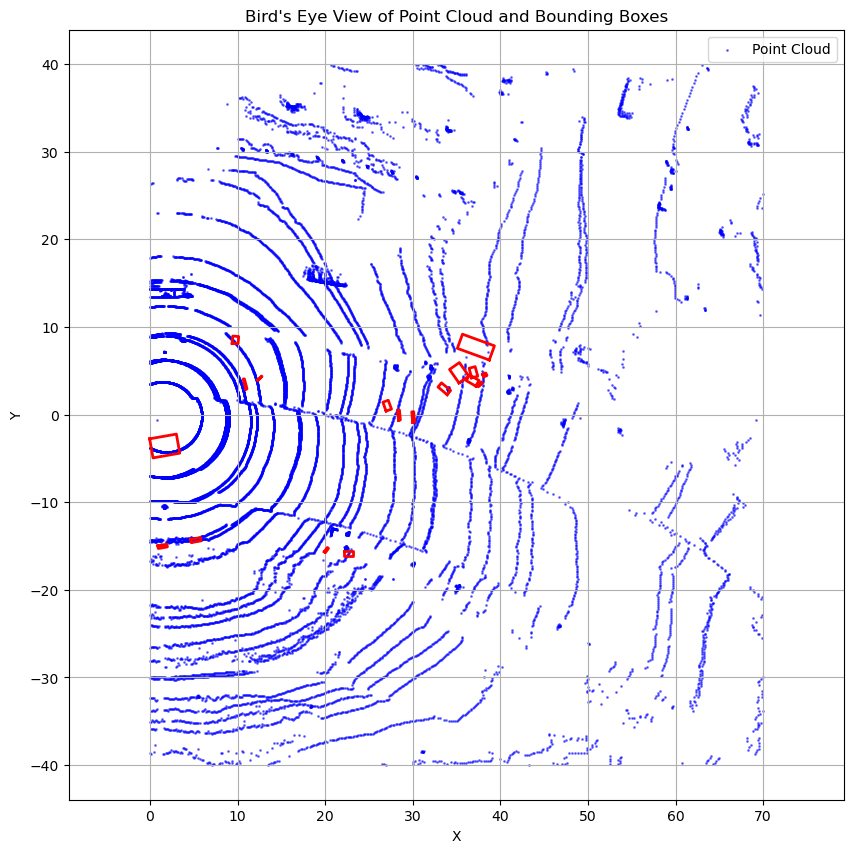

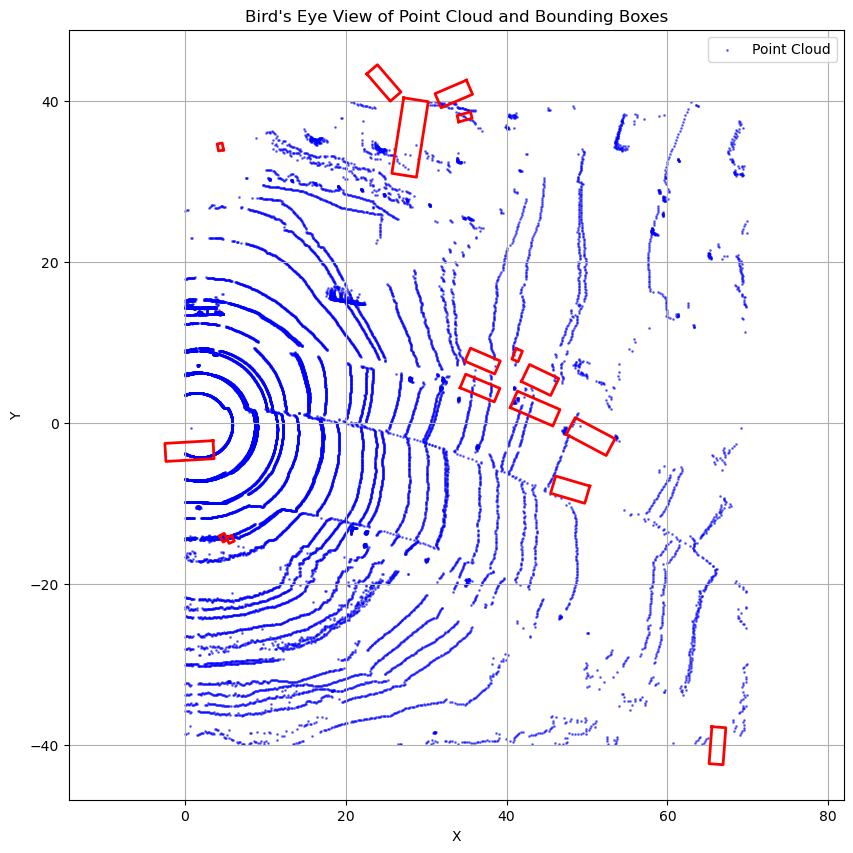

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_point_cloud_and_bboxes(points: np.ndarray, bboxes: np.ndarray):
    """
    Plots a 2D bird's eye view (BEV) of a point cloud and bounding boxes.

    Args:
        points (np.ndarray): A numpy array of shape (N, 2) representing the point cloud (x, y).
        bboxes (np.ndarray): A numpy array of shape (M, 4, 2) representing bounding boxes 
                             where each box is defined by 4 corners (x, y).
    """
    # Check input dimensions
    assert points.shape[1] == 2, "Points must have shape (N, 2)."
    assert bboxes.shape[1:] == (4, 2), "Bounding boxes must have shape (M, 4, 2)."

    plt.figure(figsize=(10, 10))
    
    # Plot the point cloud
    plt.scatter(points[:, 0], points[:, 1], s=1, color='blue', label='Point Cloud', alpha=0.5)

    # Plot each bounding box
    for bbox in bboxes:
        # Append the first corner at the end to close the bounding box
        bbox_closed = np.vstack([bbox, bbox[0]])
        plt.plot(bbox_closed[:, 0], bbox_closed[:, 1], color='red', linewidth=2)

    # Add labels, legends, and grid
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bird\'s Eye View of Point Cloud and Bounding Boxes')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.axis('equal')  # Maintain aspect ratio
    plt.show()

plot_point_cloud_and_bboxes(points_roi[:,:2], pseudo_labels)
plot_point_cloud_and_bboxes(points_roi[:,:2], gt_labels)


In [16]:
from shapely.geometry import Polygon


def convert_format(boxes_array: np.ndarray) -> Tuple[np.ndarray, List[int]]:
    # boxes_array is a numpy array of shape (N, 4, 2)
    polygons = []
    err_idxs = []
    for idx, box in enumerate(boxes_array):
        try: 
            polygon = Polygon([(point[0], point[1]) for point in box] + [(box[0, 0], box[0, 1])])
            polygons.append(polygon)
        except Exception as e:
            print(f"Error converting bbox at index {idx}: {e}")
            err_idxs.append(idx)
                            
    return np.array(polygons), err_idxs

def compute_iou(box: Polygon, boxes: List[Polygon]):
    """Calculates IoU of the given box with the array of the given boxes.
    Note: the areas are passed in rather than calculated here for efficiency. 
    Calculate once in the caller to avoid duplicate work.
    
    Args:
        box: a polygon (shapely.geometry.Polygon)
        boxes: a numpy array of shape (N,), where each member is a shapely.geometry.Polygon
    Returns:
        a numpy array of shape (N,) containing IoU values
    """
    iou_lst = []
    for b in boxes:
        intersection = box.intersection(b).area
        union = box.union(b).area
        iou = intersection / union if union > 0 else 0
        iou_lst.append(iou)
    return np.array(iou_lst, dtype=np.float32)


def compute_overlaps(boxes1: np.ndarray, boxes2: np.ndarray):
    """Computes IoU overlaps between two sets of boxes.
    Returns an overlap matrix, which contains the IoU value for each combination of boxes.
    For better performance, pass the largest set first and the smaller second.
    
    Args: 
        boxes1: a numpy array of shape (N, 4, 2)
        boxes2: a numpy array of shape (M, 4, 2)
    Returns:
        overlaps: a numpy array of shape (N, M)
    """
    
    boxes1, _ = convert_format(boxes1)
    boxes2, _ = convert_format(boxes2)
    overlaps = np.zeros((len(boxes1), len(boxes2)))
    for i in range(overlaps.shape[1]):
        box2 = boxes2[i]
        overlaps[:, i] = compute_iou(box2, boxes1)
    return overlaps


def compute_matches(gt_boxes: np.ndarray, #label_list
                    pred_boxes: np.ndarray, # corners
                    pred_scores: np.ndarray, # scores
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.
    
    Args:
        gt_boxes: [N, 4, 2] Coordinates of ground truth boxes
        pred_boxes: [N, 4, 2] Coordinates of predicted boxes
        pred_scores: [N,] Confidence scores of predicted boxes
        iou_threshold: Float. IoU threshold to determine a match.
        score_threshold: Float. Score threshold to determine a match.
    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    if len(pred_scores) == 0:
        return -1 * np.ones([gt_boxes.shape[0]]), np.array([]), np.array([])

    gt_class_ids = np.ones(len(gt_boxes), dtype=int)
    pred_class_ids = np.ones(len(pred_scores), dtype=int)

    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]

    # Compute IoU overlaps [pred_boxes, gt_boxes]
    overlaps = compute_overlaps(pred_boxes, gt_boxes)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0] #np.where returns a tuple (array, ) for 1D np array
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs: 
            # If ground truth box is already matched, go to next one
            if gt_match[j] > 0:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break #NOTE: sorted_ixs is in descending order, so if iou < iou_threshold, all the following ious will be less than iou_threshold
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps

def compute_ap(pred_match: np.ndarray, num_gt: int, num_pred: int):
    """ Compute Average Precision at a set IoU threshold (default 0.5).

        Args:
            pred_match: 1-D array. For each predicted box, it has the index of
                        the matched ground truth box.
            num_gt: Number of ground truth boxes
            num_pred: Number of predicted boxes
    """
    tp = (pred_match > -1).sum()
    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(num_pred) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / num_gt        
        
    precision = tp / num_pred
    recall = tp / num_gt
    return precision, recall

def compute_ap2(pred_match: np.ndarray, num_gt: int, num_pred: int):
    """ Compute Average Precision at a set IoU threshold (default 0.5).

        Args:
            pred_match: 1-D array. For each predicted box, it has the index of
                        the matched ground truth box.
            num_gt: Number of ground truth boxes
            num_pred: Number of predicted boxes
    """
    print(f"METHOD: compute_ap was called")
    assert num_gt != 0
    # assert num_pred != 0
    
    # Handle case when there are no predictions
    if num_pred == 0:
        print(f"METHOD: compute_ap: No predictions")
        # If there are no predictions, precision is 0 and recall depends on gt
        mAP = 0.0
        precisions = np.array([0,0])
        recalls = np.array([0, 1])  # Recall jumps from 0 to 1 over the recall range
        precision = 0.0
        recall = 0.0
        return mAP, precisions, recalls, precision, recall
    
    tp = (pred_match > -1).sum()
    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(num_pred) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / num_gt

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])
    precision = tp / num_pred
    recall = tp / num_gt
    return mAP, precisions, recalls, precision, recall


def non_max_suppression(boxes: np.ndarray, scores: np.ndarray, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    
    Args:
        boxes: numpy array of shape (N, 4, 2)
        scores: numpy array of shape (N,)    
    
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.

    return an numpy array of the positions of picks
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    polygons, err_idexes = convert_format(boxes)

    top = 64
    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1][:64]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(polygons[i], polygons[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)

    return np.array(pick, dtype=np.int32)

def filter_pred(corners, nms_iou_threshold) -> Tuple[np.ndarray, np.ndarray]:
    """
    Shape of pred is [N, 4, 2]
    
    Args: 
        pred: a numpy array of shape (N, 4, 2)
    Returns:
        corners: a numpy array of shape (N, 4, 2)
        scores: a numpy array of shape (N,)
    """
    scores = np.ones(corners.shape[0])
    selected_ids = non_max_suppression(corners, scores, nms_iou_threshold)
    corners = corners[selected_ids]
    scores = scores[selected_ids]
    return corners, scores


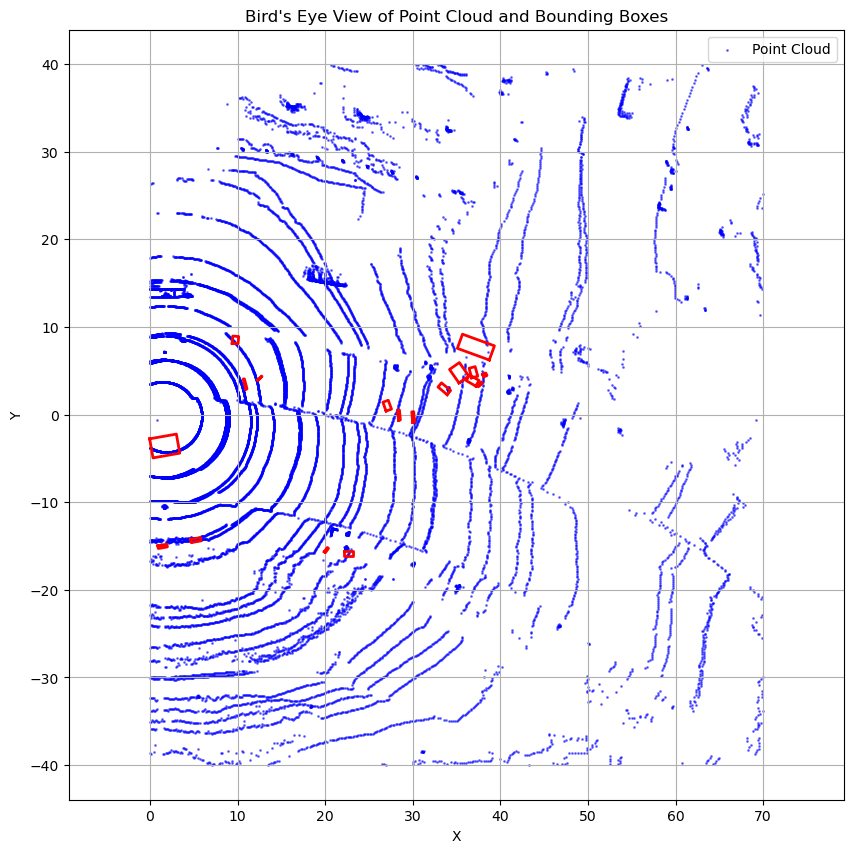

In [17]:
filtered_pseudo_labels, _ = filter_pred(pseudo_labels, 0.05)
plot_point_cloud_and_bboxes(points_roi[:,:2], filtered_pseudo_labels)


In [18]:
pred_scores = np.ones((len(pseudo_labels),))

gt_match, pred_match, overlaps = compute_matches(gt_labels, pseudo_labels, pred_scores, iou_threshold=0.5)

gt_length = len(gt_labels)
pred_length = len(pseudo_labels)
compute_ap(pred_match, len(gt_labels), len(pseudo_labels))

(0.05555555555555555, 0.0625)

In [19]:
mAP, precisions, recalls, precision, recall = compute_ap2(pred_match, gt_length, pred_length)
print(f"mAP: {mAP}, precision: {precision}, recall: {recall}")

METHOD: compute_ap was called
mAP: 0.008928571428571428, precision: 0.05555555555555555, recall: 0.0625


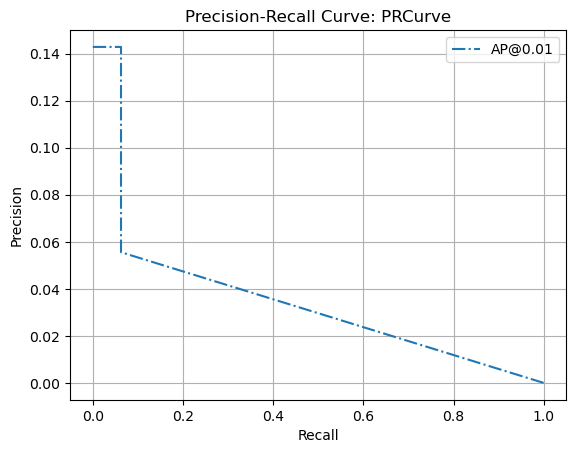

In [20]:
import matplotlib.pyplot as plt

def plot_pr_curve_in_notebook(precisions, recalls, legend, name='PRCurve'):
    """
    Plot Precision-Recall Curve in a notebook environment.

    Args:
        precisions (list or np.ndarray): Precision values.
        recalls (list or np.ndarray): Recall values.
        legend (str): Legend text to display on the plot.
        name (str): Title of the plot.
    """
    fig, ax = plt.subplots()
    ax.plot(recalls, precisions, "-.", label=legend)
    ax.set_title(f"Precision-Recall Curve: {name}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.show()

legend = f"AP@{mAP:.2f}"
plot_pr_curve_in_notebook(precisions, recalls, legend)


In [21]:
scene_path = os.path.join(pseudo_labels_dir, scene_id)

frame_detections_df = [(pd.read_feather(os.path.join(scene_path, frame_id)), frame_id.split(".")[0]) for frame_id in os.listdir(scene_path)]

In [22]:
from tracklet_claude import BidirectionalTracker, convert_to_bounding_boxes

frame_detections = [convert_to_bounding_boxes(df_frameid[0], df_frameid[1]) for df_frameid in frame_detections_df] 
two_way_tracker = BidirectionalTracker()

In [23]:
temporal_scores = two_way_tracker.track(frame_detections)

In [24]:
temporal_scores = two_way_tracker.temporal_scores

In [25]:
from enum import Enum
from tracklet_claude import BoundingBox
from prototype_utils import get_bbox_corners

class Corner(Enum):
    REAR_LEFT = 0
    REAR_RIGHT = 1
    FRONT_RIGHT = 2
    FRONT_LEFT = 3

def calculate_centroid_from_corner(corner_coords: np.ndarray, dimensions: np.ndarray, angle: float, corner_type: Corner):
    """
    Calculates the centroid of a bounding box given a corner, its dimensions, and orientation.
    
    Args:
        corner_coords: np.ndarray
            The [x, y] coordinates of the anchor corner.
        dimensions: np.ndarray
            The [length, width] of the bounding box.
        angle: float
            The orientation angle (in radians).
        corner_type: Corner (Enum)
            The type of corner (REAR_LEFT, REAR_RIGHT, FRONT_RIGHT, FRONT_LEFT).
    
    Returns:
        np.ndarray: [x, y] coordinates of the centroid. Shape (2,).
    """
    l, w = dimensions  # Length and width
    x_corner, y_corner = corner_coords  # Unpack corner coordinates
    
    # Determine unrotated offset to centroid based on corner type
    if corner_type == Corner.REAR_LEFT:
        offset = np.array([w / 2, l / 2])
    elif corner_type == Corner.REAR_RIGHT:
        offset = np.array([-w / 2, l / 2])
    elif corner_type == Corner.FRONT_RIGHT:
        offset = np.array([-w / 2, -l / 2])
    elif corner_type == Corner.FRONT_LEFT:
        offset = np.array([w / 2, -l / 2])
    else:
        raise ValueError("Invalid corner type provided.")
    
    # Rotate the offset based on the angle
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    rotated_offset = rotation_matrix @ offset
    
    # Calculate the centroid
    centroid = np.array([x_corner, y_corner]) + rotated_offset
    return centroid
    

def find_closest_corner(corners: np.ndarray, ego_vehicle: np.ndarray = None):
    """
    Finds the closest corner to the ego-vehicle.
    """
    # find the closest corner and its index in corners array
    if ego_vehicle is None:
        ego_vehicle = np.array([0, 0])
    min_dist = float("inf")
    closest_corner = None
    closest_corner_idx = None
    for i, corner in enumerate(corners):
        dist = np.linalg.norm(corner - ego_vehicle)
        if dist < min_dist:
            min_dist = dist
            closest_corner = corner
            closest_corner_idx = i
    
    return closest_corner, closest_corner_idx

def refine_bbox(bbox_tracklet_dict: Dict, r_percentile=95):
    """
    Refines a bbox by finding the closet corner to ego-vehicle 
    and updating the lenght and width of the box.
    
    Args:
        bbox_tracklet_dict: Dict
            A dictionary containing a bbox and a tracklet.
            {"bbox": BoundingBox, forward_tracklet: Tracklet, backward_tracklet: Tracklet}
        r_percentile: int
            
    Returns:
        BoundingBox: A refined bounding box.
    """

    # find corner closest to ego-vehicle
    bbox = bbox_tracklet_dict["bbox"]
    corners = get_bbox_corners((bbox.x, bbox.y, bbox.l, bbox.w, bbox.theta))
    
    closest_corner, closest_corner_idx = find_closest_corner(corners)
    
    corner_type = Corner(closest_corner_idx)
    
    forward_dimensions_lst = [(bbox.l, bbox.w) for bbox in bbox_tracklet_dict["forward_tracklet"].boxes]
    backward_dimesnions_lst = [(bbox.l, bbox.w) for bbox in bbox_tracklet_dict["backward_tracklet"].boxes]
    
    # find 95th percentile of the dimensions
    new_dimensions = np.percentile(forward_dimensions_lst, r_percentile, axis=0)
    
    new_centroid = calculate_centroid_from_corner(closest_corner, new_dimensions, bbox.theta, corner_type)
    
    new_bbox = BoundingBox(new_centroid[0], new_centroid[1], new_dimensions[0], new_dimensions[1], bbox.theta, frame_id=bbox.frame_id)
    
    return new_bbox

def refine_tracklets(bbox_trackelts_lst_lst_dic: List[List[Dict]]) -> List[List[BoundingBox]]:
    """
    Refines tracklets by filtering out bboxes with low temporal scores and refining the bboxes of an entire scene
    
    Args:
        bbox_trackelts_lst_lst_dic: List[List[Dict]]
            A list of list of dictionaries containing bboxes and tracklets.
            Each sublist corresponds to a single frame and is a list of bboxes(detections) for that frame.
            Each elem in frame_detectiosn_df => (df, frame_id)  
            Each dictionary in the sublist contains a bbox and its corresponding tracklet.

    Returns:
        List[List[BoundingBox]]: A list of list of refined bounding boxes.
        
    List[BoundingBox] represents a single frame and
    List[List[BoundingBox]] represents a single scene.
    """
    filtered_lst_lst_dic = []
    q = 6
    for frame in bbox_trackelts_lst_lst_dic:
        filtered_frame = []
        for bbox_tracklet_dict in frame:
            # print(f"type of bbox_tracklet_tuple: {type(bbox_tracklet_tuple)}")
            if bbox_tracklet_dict["bbox"].temporal_score > q:
                # print(f"temporal score is {bbox_tracklet_dict['bbox'].temporal_score}")
                filtered_frame.append(bbox_tracklet_dict)
            
        filtered_lst_lst_dic.append(filtered_frame)
        
    filtered_scenes_list = []
    for frame in bbox_trackelts_lst_lst_dic:
        filtered_frames_lst = []
        for bbox_tracklet_dict in frame:
            new_bbox = refine_bbox(bbox_tracklet_dict)
            filtered_frames_lst.append(new_bbox)
        filtered_scenes_list.append(filtered_frames_lst)
    
    return filtered_scenes_list

In [26]:
temporal_scores[0][0]

{'bbox': BoundingBox(x=27.855419310700974, y=-0.045592149245322844, l=3.533238912744942, w=0.4202619352687841, theta=1.3089969389957472, id=1551718381757859584, temporal_score=12, frame_id='315968335160099000'),
 'forward_tracklet': Tracklet(id=18, boxes=[BoundingBox(x=27.855419310700974, y=-0.045592149245322844, l=3.533238912744942, w=0.4202619352687841, theta=1.3089969389957472, id=1551718381757859584, temporal_score=12, frame_id='315968335160099000')], confidence=0.9, velocities=[], length=1),
 'backward_tracklet': Tracklet(id=521, boxes=[BoundingBox(x=31.718208777468785, y=12.279723587995571, l=1.3349646798337824, w=0.49856391795070026, theta=2.792526803190927, id=14917672804426501061, temporal_score=0, frame_id='315968336260252000'), BoundingBox(x=31.63762016450599, y=12.067995051797904, l=0.8546471419983575, w=0.1808596423404676, theta=0.2617993877991494, id=136369881965772553, temporal_score=2, frame_id='315968336160056000'), BoundingBox(x=31.557031551543194, y=11.85626651560023

In [27]:
refined_bboxes = refine_tracklets(temporal_scores)

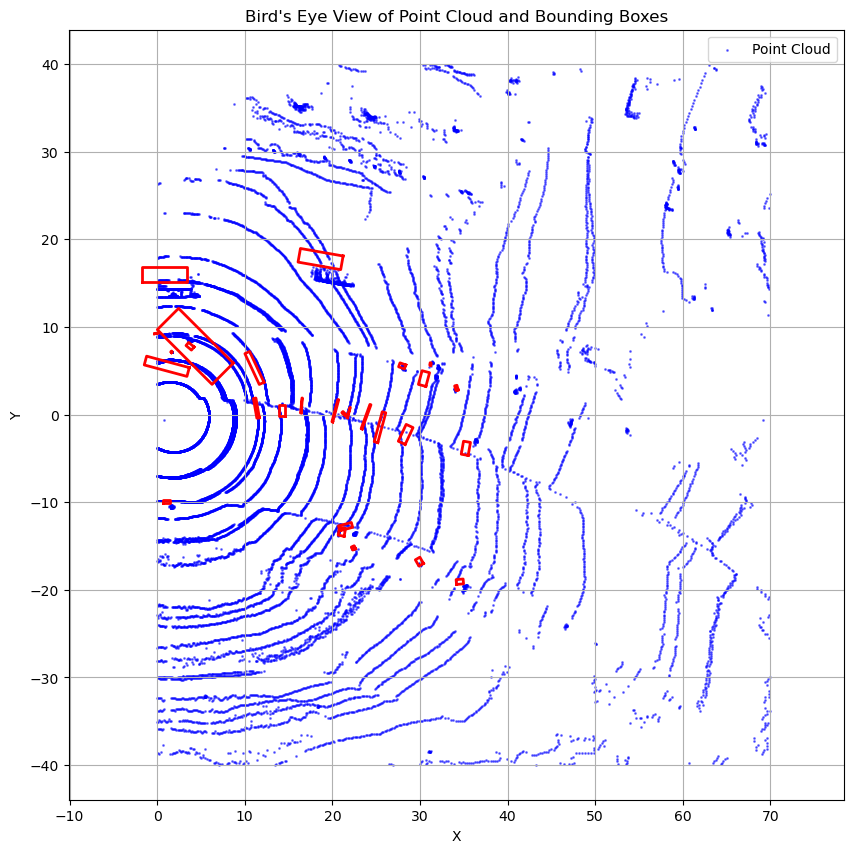

In [28]:
refined_bboxes_corners = [get_bbox_corners((bbox.x, bbox.y, bbox.l, bbox.w, bbox.theta)) for bbox in refined_bboxes[0]]
refined_bboxes_corners = np.array(refined_bboxes_corners)
plot_point_cloud_and_bboxes(points_roi[:,:2], refined_bboxes_corners)

In [ ]:
_ , pred_match_refined, _ = compute_matches(gt_labels, refined_bboxes_corners, pred_scores, iou_threshold=0.5)

gtl = len(gt_labels)
pred_l = len(pred_match_refined)

mAP, precisions, recalls, precision, recall = compute_ap2(pred_match_refined, gtl, pred_l)

In [ ]:
print(f"mAP: {mAP}, recall: {recall}, precision: {precision}")

# mAP: 0.01001082280916827,  recall: 0.09090909090909091, precision: 0.07142857142857142

In [ ]:
plot_pr_curve_in_notebook(precisions, recalls, legend)